# **Step 1: Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 2: Clone the GitHub Repository**

In [ ]:
!git clone https://github.com/NVIDIA/pix2pixHD.git
%cd pix2pixHD
!pip install dominate
!pip install torch torchvision

fatal: destination path 'pix2pixHD' already exists and is not an empty directory.
/content/pix2pixHD


# **Step 3: Organize Dataset into Training and Validation Folders**

In [ ]:
import os, shutil, random

# Set up your original mask/photo folders
masks_dir = '/content/drive/MyDrive/MBL 559E - Group Project/Fifth Test/U2Net_Cl_resized_segmn'
images_dir = '/content/drive/MyDrive/MBL 559E - Group Project/Fifth Test/U2Net_Cl_resized_augm'
root = '/content/pix2pixHD/datasets/yalihouse_hd/'

# Make sure destination folders exist and are empty
for folder in ['train_A', 'train_B', 'val_A', 'val_B']:
    dest = os.path.join(root, folder)
    os.makedirs(dest, exist_ok=True)
    # Remove old files if any
    for f in os.listdir(dest):
        os.remove(os.path.join(dest, f))

# Get list of mask files
mask_files = [f for f in os.listdir(masks_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(mask_files)

split = int(0.9 * len(mask_files))
train_files = mask_files[:split]
val_files = mask_files[split:]

def process_split(files, A_dir, B_dir):
    for fname in files:
        base = os.path.splitext(fname)[0].replace('_mask', '')
        mask_path = os.path.join(masks_dir, fname)
        img_path = None
        for ext in ['.png', '.jpg', '.jpeg']:
            candidate = os.path.join(images_dir, base + ext)
            if os.path.exists(candidate):
                img_path = candidate
                break
        if not img_path:
            print(f"No image found for mask {fname}")
            continue
        # Copy to A and B
        shutil.copy(mask_path, os.path.join(A_dir, base + '.png'))
        shutil.copy(img_path, os.path.join(B_dir, base + '.png'))

# Fill train/val
process_split(train_files, os.path.join(root, 'train_A'), os.path.join(root, 'train_B'))
process_split(val_files, os.path.join(root, 'val_A'), os.path.join(root, 'val_B'))

# Check results
print("train_A:", len(os.listdir(os.path.join(root, 'train_A'))))
print("train_B:", len(os.listdir(os.path.join(root, 'train_B'))))
print("val_A:", len(os.listdir(os.path.join(root, 'val_A'))))
print("val_B:", len(os.listdir(os.path.join(root, 'val_B'))))


train_A: 1481
train_B: 1481
val_A: 165
val_B: 165


In [ ]:
import cv2
import os

folders = [
    '/content/pix2pixHD/datasets/yalihouse_hd/train_A',
    '/content/pix2pixHD/datasets/yalihouse_hd/train_B',
    '/content/pix2pixHD/datasets/yalihouse_hd/val_A',
    '/content/pix2pixHD/datasets/yalihouse_hd/val_B'
]

size = (256, 256)  # Change this if you want to use a different size!

for folder in folders:
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        try:
            img = cv2.imread(fpath)
            if img is None:
                print(f"Failed to load {fpath}, skipping.")
                continue
            if img.shape[:2] != size[::-1]:
                img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
                cv2.imwrite(fpath, img)
        except Exception as e:
            print(f"Error processing {fpath}: {e}")

print("✅ All images are now resized to", size)


✅ All images are now resized to (256, 256)


# **Step 4: Train the Pix2PixHD Model**

In [ ]:
!python train.py --name yalihouse_hd \
  --dataroot datasets/yalihouse_hd \
  --label_nc 0 \
  --no_instance \
  --resize_or_crop none \
  --batchSize 8 \
  --save_epoch_freq 5


------------ Options -------------
batchSize: 8
beta1: 0.5
checkpoints_dir: ./checkpoints
continue_train: False
data_type: 32
dataroot: datasets/yalihouse_hd
debug: False
display_freq: 100
display_winsize: 512
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
input_nc: 3
instance_feat: False
isTrain: True
label_feat: False
label_nc: 0
lambda_feat: 10.0
loadSize: 1024
load_features: False
load_pretrain: 
local_rank: 0
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: yalihouse_hd
ndf: 64
nef: 16
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_instance: True
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: train
pool_size: 0
print_freq: 100
resize_or_crop: none
save_epoch_freq: 5
save_latest_freq: 1000
serial_batches: False
tf_log: False


# **Step 5: Organize Dataset into test A and test B**

In [ ]:
import os, shutil

root = '/content/pix2pixHD/datasets/yalihouse_hd/'
os.makedirs(root + 'test_A', exist_ok=True)
os.makedirs(root + 'test_B', exist_ok=True)

# Copy files (overwrite if already exists)
for fname in os.listdir(root + 'val_A'):
    shutil.copy(os.path.join(root + 'val_A', fname), os.path.join(root + 'test_A', fname))
for fname in os.listdir(root + 'val_B'):
    shutil.copy(os.path.join(root + 'val_B', fname), os.path.join(root + 'test_B', fname))

print("✅ val_A/B copied to test_A/B")

✅ val_A/B copied to test_A/B


In [ ]:
import os

test_a_dir = '/content/pix2pixHD/datasets/yalihouse_hd/test_A'
test_b_dir = '/content/pix2pixHD/datasets/yalihouse_hd/test_B'

test_a_files = set([f for f in os.listdir(test_a_dir) if f.lower().endswith(('.jpg','.png'))])
test_b_files = set([f for f in os.listdir(test_b_dir) if f.lower().endswith(('.jpg','.png'))])

paired = test_a_files & test_b_files
missing_in_b = test_a_files - test_b_files
missing_in_a = test_b_files - test_a_files

print(f"Paired: {len(paired)}")
if missing_in_b:
    print(f"Missing in test_B: {sorted(list(missing_in_b))}")
if missing_in_a:
    print(f"Missing in test_A: {sorted(list(missing_in_a))}")

Paired: 307


# **Step 6: Test the Pix2Pix Model**

In [ ]:
!python test.py --name yalihouse_hd \
  --dataroot datasets/yalihouse_hd \
  --label_nc 0 \
  --no_instance \
  --resize_or_crop none \
  --how_many 50 \
  --phase test

------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
data_type: 32
dataroot: datasets/yalihouse_hd
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_local_enhancers: 1
name: yalihouse_hd
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: True
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: none
results_dir: ./results/
serial_batches: False
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset]

# **Step 7: Visualize Pix2PixHD Output Results**

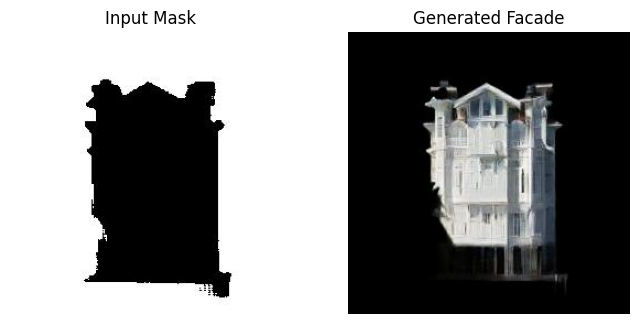

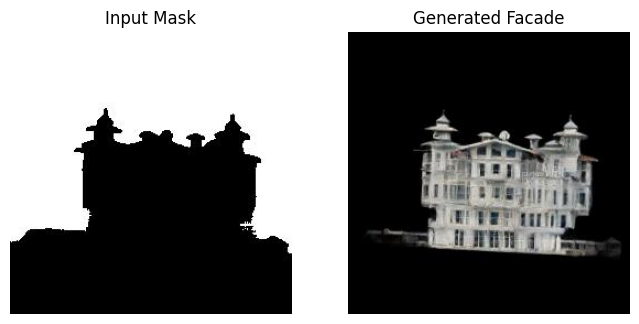

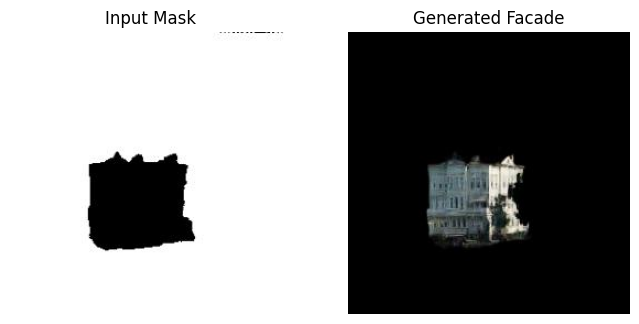

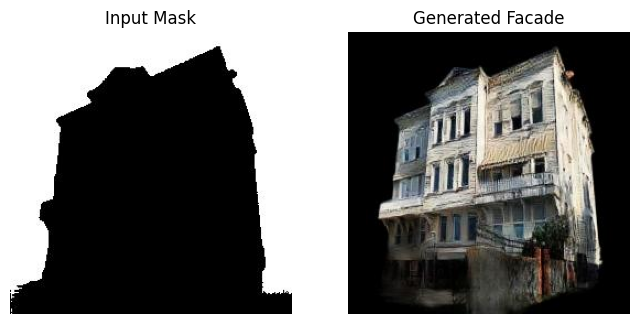

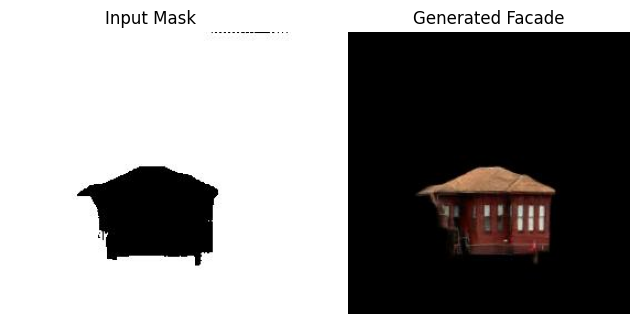

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

result_dir = '/content/pix2pixHD/results/yalihouse_hd/test_latest/images'
files = sorted([f for f in os.listdir(result_dir) if 'synthesized_image' in f])[:5]

def find_img(base, suffix):
    for ext in ['.jpg', '.jpeg', '.png']:
        fname = base + suffix + ext
        fpath = os.path.join(result_dir, fname)
        if os.path.exists(fpath):
            return fpath
    return None

for synth_name in files:
    # Remove either .jpg or .png from the synthesized image name to get the base
    if synth_name.endswith('.jpg'):
        base = synth_name.replace('_synthesized_image.jpg', '')
    elif synth_name.endswith('.png'):
        base = synth_name.replace('_synthesized_image.png', '')
    else:
        continue

    input_path = find_img(base, '_input_label')
    synth_path = os.path.join(result_dir, synth_name)

    if not (input_path and os.path.exists(synth_path)):
        print(f"Skipping {base}: one or more files missing.")
        continue

    img_input = cv2.imread(input_path)
    img_synth = cv2.imread(synth_path)

    if img_input is None or img_synth is None:
        print(f"Skipping {base}: could not load one or more images.")
        continue

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)); axs[0].set_title('Input Mask')
    axs[1].imshow(cv2.cvtColor(img_synth, cv2.COLOR_BGR2RGB)); axs[1].set_title('Generated Facade')
    for ax in axs: ax.axis('off')
    plt.show()


In [ ]:
logfile = '/content/pix2pixHD/checkpoints/yalihouse_hd/loss_log.txt'
import os

print("Exists:", os.path.exists(logfile))
if os.path.exists(logfile):
    with open(logfile) as f:
        lines = f.readlines()
        print(f"Lines in loss_log.txt: {len(lines)}")
        for i in range(min(5, len(lines))):
            print(lines[i].strip())

Exists: True
Lines in loss_log.txt: 2105
================ Training Loss (Fri Jun 13 16:26:43 2025) ================
================ Training Loss (Fri Jun 13 16:34:44 2025) ================
(epoch: 1, iters: 200, time: 0.020) G_GAN: 1.752 G_GAN_Feat: 6.886 G_VGG: 6.266 D_real: 1.256 D_fake: 1.139
(epoch: 1, iters: 400, time: 0.015) G_GAN: 1.166 G_GAN_Feat: 5.083 G_VGG: 5.497 D_real: 1.079 D_fake: 1.326
(epoch: 1, iters: 600, time: 0.015) G_GAN: 0.676 G_GAN_Feat: 4.031 G_VGG: 6.286 D_real: 0.581 D_fake: 0.524


# **Step 8: Plot GAN Training Losses Over Time**

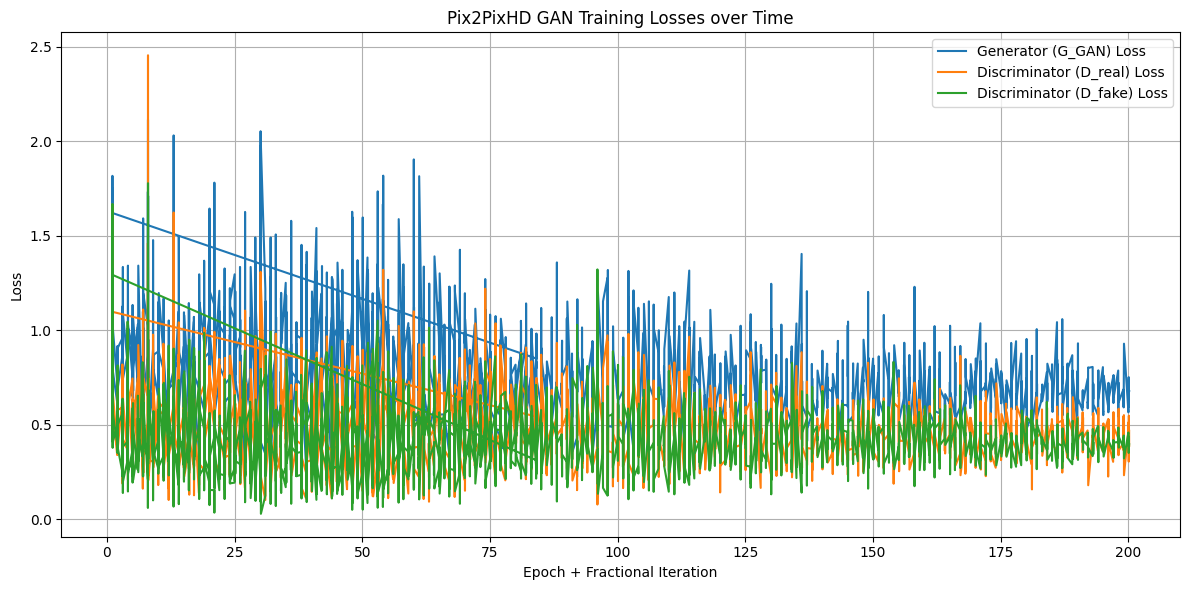

In [ ]:
import matplotlib.pyplot as plt
import re

logfile = '/content/pix2pixHD/checkpoints/yalihouse_hd/loss_log.txt'

iters = []
g_gan, d_real, d_fake = [], [], []

with open(logfile, 'r') as f:
    for line in f:
        # Only process lines with actual loss values
        if line.startswith('(epoch:'):
            # Use regular expressions to extract numbers
            match = re.search(
                r'\(epoch: (\d+), iters: (\d+), time: [\d.]+\) G_GAN: ([\d.]+) G_GAN_Feat: [\d.]+ G_VGG: [\d.]+ D_real: ([\d.]+) D_fake: ([\d.]+)',
                line)
            if match:
                epoch = int(match.group(1))
                iteration = int(match.group(2))
                iters.append(epoch + iteration / 10000)  # For smooth x-axis
                g_gan.append(float(match.group(3)))
                d_real.append(float(match.group(4)))
                d_fake.append(float(match.group(5)))

plt.figure(figsize=(12, 6))
plt.plot(iters, g_gan, label='Generator (G_GAN) Loss')
plt.plot(iters, d_real, label='Discriminator (D_real) Loss')
plt.plot(iters, d_fake, label='Discriminator (D_fake) Loss')
plt.xlabel('Epoch + Fractional Iteration')
plt.ylabel('Loss')
plt.title('Pix2PixHD GAN Training Losses over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/content/pix2pixHD/checkpoints/yalihouse_hd/loss_curve.png', dpi=200)
plt.show()

# **Step 9: Export Generated Images as ZIP File**

In [ ]:
import shutil
import os

# Set the directory where your generated images are located
result_dir = '/content/pix2pixHD/results/yalihouse_hd/test_latest/images'
zip_name = '/content/yalihouse_pix2pixhd_generated.zip'

# Remove zip if it already exists (to avoid errors)
if os.path.exists(zip_name):
    os.remove(zip_name)

# Create a ZIP file of all generated images
shutil.make_archive(zip_name.replace('.zip', ''), 'zip', result_dir)

print(f'Zipped all generated images to {zip_name}')

Zipped all generated images to /content/yalihouse_pix2pixhd_generated.zip


In [ ]:
import os

gen_dir = '/content/pix2pixHD/results/yalihouse_hd/test_latest/images'
real_dir = '/content/pix2pixHD/datasets/yalihouse_hd/test_B'

# List all generated images
gen_files = [f for f in os.listdir(gen_dir) if f.endswith('_synthesized_image.jpg')]

pairs = []
for g in gen_files:
    base = g.replace('_synthesized_image.jpg', '')  # e.g., y_001_01_aug2
    # Look for the corresponding real image
    # Try .jpg and .png, just in case
    for ext in ['.jpg', '.png']:
        real_path = os.path.join(real_dir, base + ext)
        gen_path = os.path.join(gen_dir, g)
        if os.path.exists(real_path):
            pairs.append((gen_path, real_path))
            break

print(f"Found {len(pairs)} valid pairs for metric computation.")

Found 50 valid pairs for metric computation.


# **Step 10: Evaluation Scores**

**Step 10.1: SSIM Score**

In [ ]:
!pip install scikit-image

In [ ]:
import cv2
from skimage.metrics import structural_similarity as ssim

ssim_scores = []
for gen_path, real_path in pairs:
    img_gen = cv2.imread(gen_path)
    img_real = cv2.imread(real_path)
    if img_gen is None or img_real is None:
        continue
    # Resize to match if needed
    if img_gen.shape != img_real.shape:
        img_real = cv2.resize(img_real, (img_gen.shape[1], img_gen.shape[0]))
    score = ssim(img_gen, img_real, channel_axis=-1)
    ssim_scores.append(score)

if ssim_scores:
    print(f"Average SSIM over {len(ssim_scores)} pairs: {sum(ssim_scores)/len(ssim_scores):.4f}")
else:
    print("No valid SSIM scores calculated.")

Average SSIM over 50 pairs: 0.8207


**Step 10.2: FID Score**

In [ ]:
# Install if not done
!pip install pytorch-fid

# First, copy generated images and real images into two folders (e.g., /tmp/fake, /tmp/real)
import shutil

fake_dir = '/tmp/pix2pixhd_fake'
real_dir2 = '/tmp/pix2pixhd_real'
os.makedirs(fake_dir, exist_ok=True)
os.makedirs(real_dir2, exist_ok=True)

for idx, (gen_path, real_path) in enumerate(pairs):
    shutil.copy(gen_path, os.path.join(fake_dir, f'{idx}.jpg'))
    shutil.copy(real_path, os.path.join(real_dir2, f'{idx}.jpg'))

# Now run FID calculation
!python -m pytorch_fid /tmp/pix2pixhd_real /tmp/pix2pixhd_fake

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 275MB/s]
100% 1/1 [00:00<00:00,  1.53it/s]
100% 1/1 [00:00<00:00,  3.39it/s]
FID:  72.9044467852417


**Step 10.3: CLIP Score**

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v_dazdmp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v_dazdmp
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=410531bb338c6f5099cface828fbac723afca6f392881f9961e637a9084b4cee
  Stored in directory: /tmp/pip-ephem-wheel-cache-2h83l4ne/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [ ]:
import os
import torch
import clip
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

text = ["Istanbul Bosphorus Waterfront Houses"]  # Your prompt
text_tokens = clip.tokenize(text).to(device)

image_dir = "/content/pix2pixHD/results/yalihouse_hd/test_latest/images"
images = [f for f in os.listdir(image_dir) if f.endswith("_synthesized_image.jpg")]

scores = []
for img_name in images:
    img_path = os.path.join(image_dir, img_name)
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text_tokens)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (image_features @ text_features.T).cpu().numpy()[0][0]
    scores.append(similarity)

print(f"Average CLIP Score: {np.mean(scores):.4f}")

100%|███████████████████████████████████████| 338M/338M [00:13<00:00, 25.3MiB/s]


Average CLIP Score: 0.2262
